# **Object Detection Using Adaptive Mask RCNN in Optical Remote Sensing Images**

<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrSPYhRJMV_8uxVLpEuSAYoN96FGXBMrjZF47uhqBcAA&s" alt="Description de l'image" width="800"></center>


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
import itertools
import warnings
warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#### **Load Data**

In [ ]:
pos_dir = "dataset/positive"
bbox_dir = 'dataset/ground'
neg_dir = 'dataset/negative'


In [ ]:
!ls 'dataset'

'ground truth'	'negative image set'  'positive image set'   readme.txt


##### **Ground truth**

In [ ]:
import os
if not os.path.exists(bbox_dir):
    raise FileNotFoundError(f"The directory '{bbox_dir}' does not exist.")

annotations = []

pattern = r'\(\s*(\d+)\s*,\s*(\d+)\s*\),\s*\(\s*(\d+)\s*,\s*(\d+)\s*\),\s*(\d+)'

for filename in os.listdir(bbox_dir):
    with open(os.path.join(bbox_dir, filename), 'r') as file:
        lines = file.readlines()
        for line in lines:
            match = re.match(pattern, line.strip())

            if match:
                x1, y1, x2, y2, obj_class = map(int, match.groups())
                annotations.append({'filename': filename, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'class': obj_class})


gt_dataset = pd.DataFrame(annotations)


In [ ]:
gt_dataset.head()

filename   x1   y1    x2   y2  class
0  559.txt   56  117   215  239      9
1  559.txt  611   38   694  183      9
2  559.txt  953   46  1092  182      9
3  557.txt  108  287   351  422      9
4  557.txt  818   58   934  232      9

* Summary statistics of bounding box coordinates and classes.

In [ ]:
print(gt_dataset.describe())

                x1           y1           x2           y2        class
count  3896.000000  3896.000000  3896.000000  3896.000000  3896.000000
mean    462.985113   273.663758   541.246150   347.442248     4.745637
std     270.804982   170.519470   266.565838   167.006578     3.096602
min       1.000000     1.000000    33.000000    38.000000     1.000000
25%     254.000000   138.000000   338.000000   219.000000     2.000000
50%     437.000000   248.000000   521.000000   331.000000     4.000000
75%     646.000000   384.000000   711.000000   450.000000     7.000000
max    1636.000000   894.000000  1704.000000   958.000000    10.000000


Count of objects per class

In [ ]:
class_map = {
    1: 'airplane',
    2: 'ships',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

class_counts = gt_dataset['class'].map(class_map).value_counts()
print(class_counts)


class
airplane              757
storage tank          655
vehicle               598
tennis court          524
baseball diamond      390
ships                 302
harbor                224
ground track field    163
basketball court      159
bridge                124
Name: count, dtype: int64


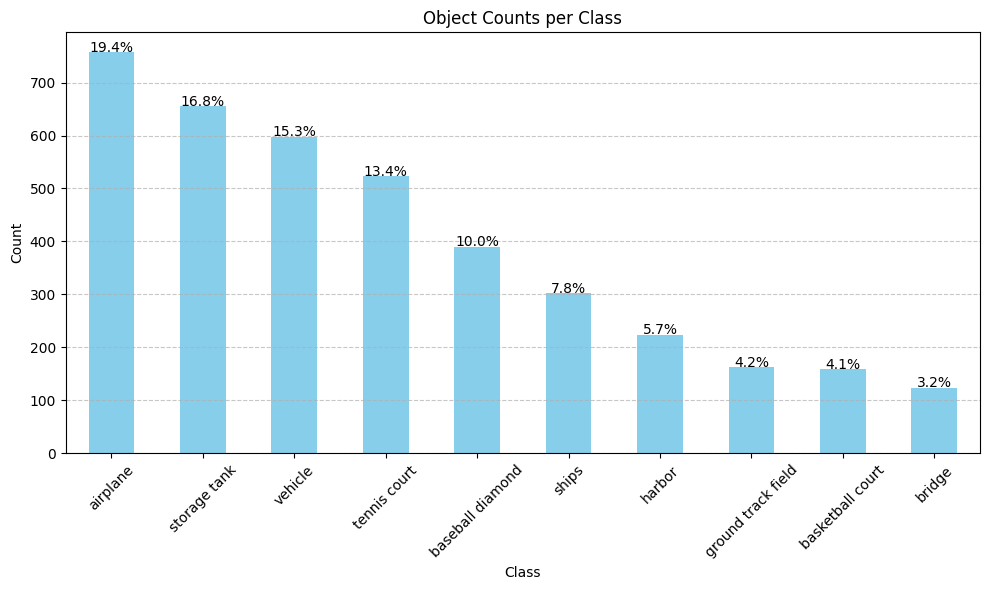

In [ ]:
total_objects = class_counts.sum()
class_percentages = (class_counts / total_objects) * 100

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Object Counts per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.5, f'{class_percentages[i]:.1f}%', ha='center')

plt.tight_layout()
plt.show()

##### **Positive Images**

Load positive images

In [ ]:

def load_images_from_folder(folder):
    images = []
    filenames = []
    original_sizes = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            original_size = img.shape[:2]  
            original_sizes.append(original_size)
            images.append(img)
            filenames.append(filename)
    return images, filenames, original_sizes

2024-05-08 17:47:57.664731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 17:47:57.664839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 17:47:57.798907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
positive_images, positive_filenames, positive_original_sizes = load_images_from_folder(pos_dir)

In [ ]:
positive_image_count = len(os.listdir(pos_dir))

print(f"Number of images in positive image set: {positive_image_count}")

Number of images in positive image set: 650


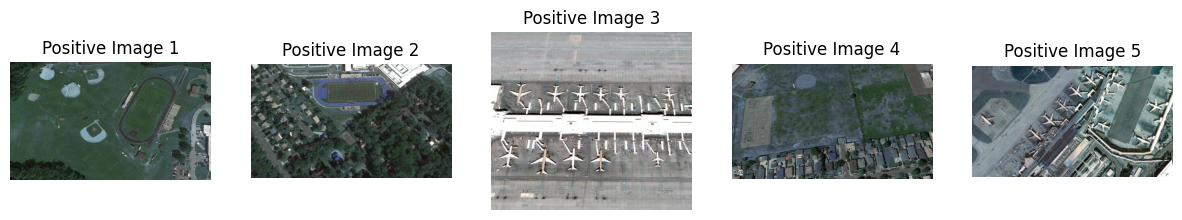

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(positive_images[i])
    plt.title(f'Positive Image {i+1}')
    plt.axis('off')

plt.show()

Load annotations for positive images

In [ ]:
def load_annotations_from_folder(folder, filenames, target_size=(224, 224)):
    annotations = []
    for idx, filename in enumerate(filenames):
        annot_filename = os.path.splitext(filename)[0] + '.txt'
        annot_file = os.path.join(folder, annot_filename)
        boxes = []
        with open(annot_file, 'r') as file:
            for line in file.readlines():
                parts = line.replace('(', '').replace(')', '').replace(',', ' ').split()
                i = 0
                while i < len(parts) - 4:
                    try:
                        x_min = int(float(parts[i].strip()))
                        y_min = int(float(parts[i+1].strip()))
                        x_max = int(float(parts[i+2].strip()))
                        y_max = int(float(parts[i+3].strip()))
                        class_id = int(parts[i+4].strip())
                        boxes.append([x_min, y_min, x_max, y_max, class_id])
                        i += 10
                    except ValueError as e:
                        print(f"Error parsing line '{line}': {e}")
                        i += 10
        annotations.append(boxes)
    return annotations

In [ ]:
positive_annotations = load_annotations_from_folder(bbox_dir, positive_filenames)

In [ ]:
for idx, annot in enumerate(positive_annotations[:5]):
    print(f"Annotations for image {idx + 1}: {annot}")

Annotations for image 1: [[500, 65, 776, 388, 7], [135, 25, 212, 89, 4], [343, 27, 442, 112, 4], [236, 93, 330, 171, 4], [324, 273, 454, 380, 4]]
Annotations for image 2: [[293, 69, 665, 194, 7], [427, 330, 494, 381, 5]]
Annotations for image 3: [[66, 186, 142, 272, 1], [204, 191, 268, 260, 1], [297, 190, 361, 261, 1], [374, 197, 433, 255, 1], [448, 199, 505, 251, 1], [621, 194, 686, 256, 1], [27, 417, 104, 501, 1], [142, 419, 242, 524, 1], [262, 420, 341, 510, 1], [364, 422, 443, 518, 1], [587, 438, 641, 501, 1]]
Annotations for image 4: [[72, 167, 126, 239, 6], [134, 163, 185, 233, 6], [65, 247, 118, 316, 6], [127, 239, 182, 311, 6], [57, 327, 111, 405, 6], [120, 318, 175, 395, 6]]
Annotations for image 5: [[44, 259, 123, 334, 1], [292, 313, 371, 400, 1], [360, 245, 443, 323, 1], [437, 171, 513, 245, 1], [507, 96, 585, 172, 1], [579, 31, 660, 109, 1], [740, 65, 811, 140, 1], [660, 275, 736, 356, 1], [921, 159, 1007, 256, 1], [843, 332, 944, 438, 1]]


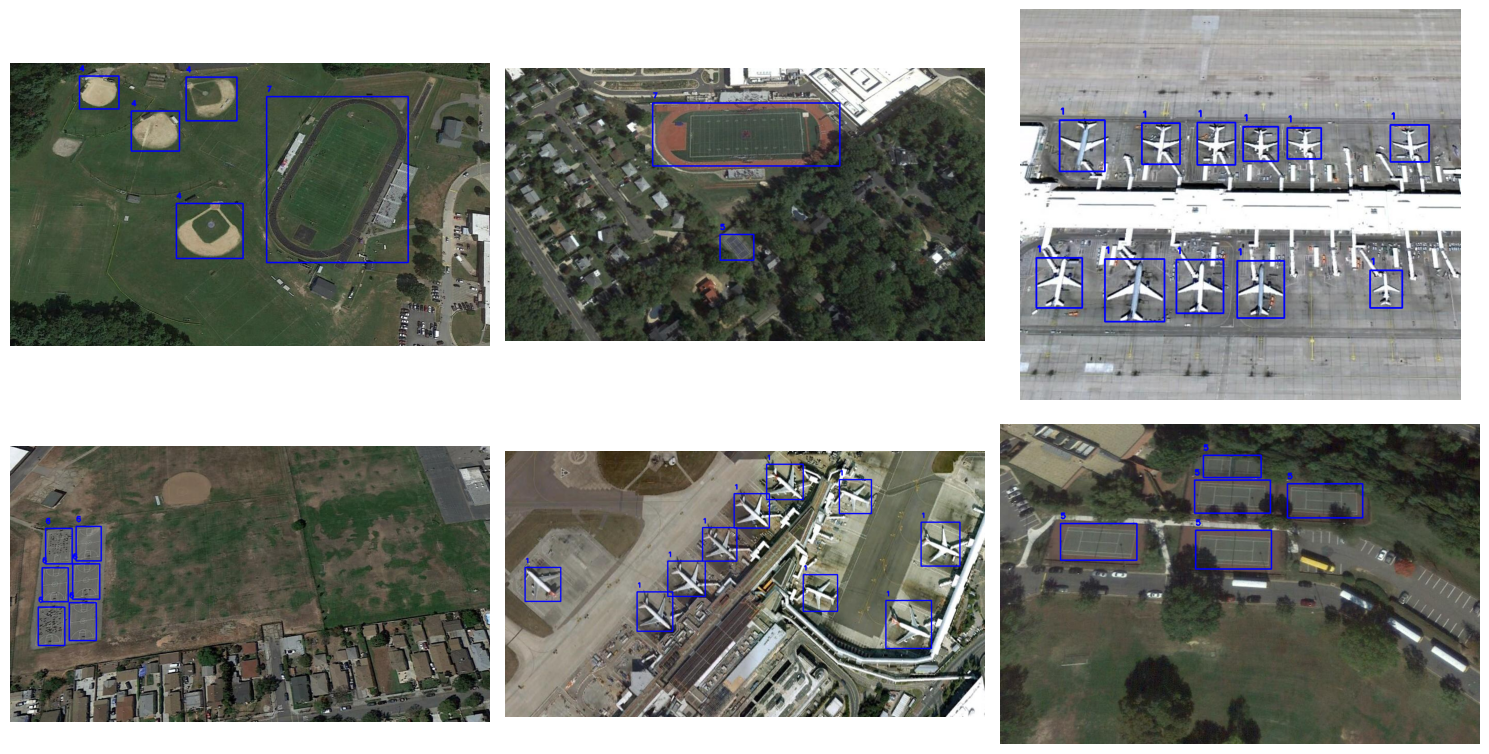

In [ ]:
def draw_boxes(img, boxes):
    for box in boxes:
        x_min, y_min, x_max, y_max, label = box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, str(label), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return img

images_with_boxes = []
for img, annot in zip(positive_images[:6], positive_annotations[:6]):
    img_with_boxes = draw_boxes(img.copy(), annot)
    images_with_boxes.append(img_with_boxes)

plt.figure(figsize=(15, 8))
for i, img_with_boxes in enumerate(images_with_boxes, start=1):
    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.tight_layout()
plt.show()

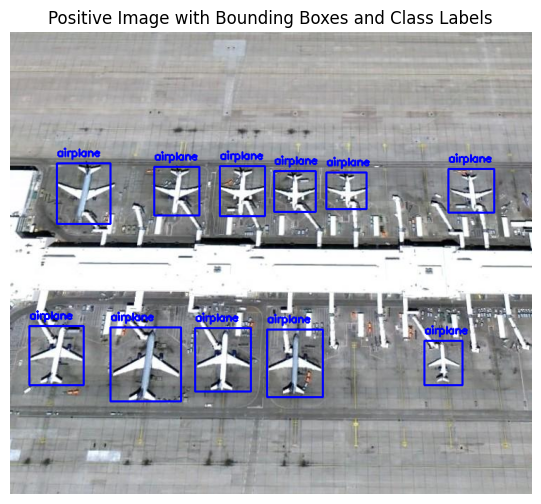

In [ ]:
number_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
class_labels = ['background','airplane', 'ships', 'storage tank', 'baseball diamond', 'tennis court', 'basketball court', 'ground track field', 'harbor', 'bridge', 'vehicle']

mapping_dict = {number: label for number, label in zip(number_list, class_labels)}
def draw_boxes_with_labels(img, boxes, class_labels):
    for box, label in zip(boxes, class_labels):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return img

sample_index = 2
sample_image = positive_images[sample_index]
sample_annotations = positive_annotations[sample_index]

boxes = [annot[:4] for annot in sample_annotations]
class_labels = [mapping_dict[annot[4]] for annot in sample_annotations]  

image_with_boxes = draw_boxes_with_labels(sample_image.copy(), boxes, class_labels)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Positive Image with Bounding Boxes and Class Labels')
plt.show()


##### **Negative Images**

Load negative images

In [ ]:
negative_images, negative_filenames, negative_original_sizes = load_images_from_folder(neg_dir)

In [ ]:
negative_image_count = len(os.listdir(neg_dir))

print(f"Number of images in negative image set: {negative_image_count}")


Number of images in negative image set: 150


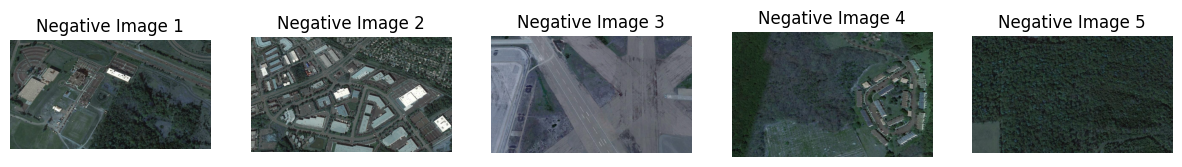

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(negative_images[i])
    plt.title(f'Negative Image {i+1}')
    plt.axis('off')



Distribution of images by type (positive/negative)

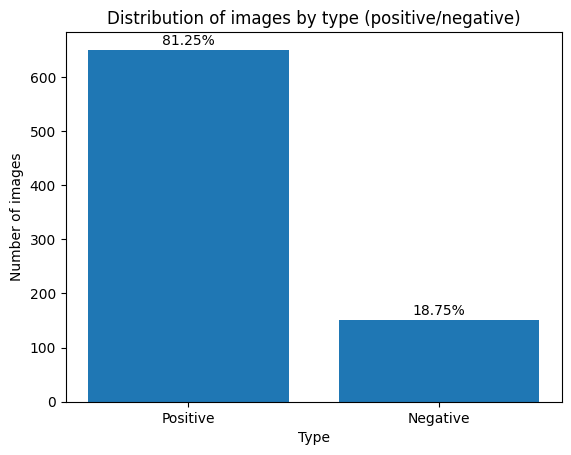

In [ ]:
total_images = negative_image_count + positive_image_count
percentage_positive = (positive_image_count / total_images) * 100
percentage_negative = (negative_image_count / total_images) * 100

plt.bar(['Positive', 'Negative'], [positive_image_count, negative_image_count])
plt.text(0, positive_image_count + 10, f'{percentage_positive:.2f}%', ha='center')
plt.text(1, negative_image_count + 10, f'{percentage_negative:.2f}%', ha='center')
plt.title('Distribution of images by type (positive/negative)')
plt.xlabel('Type')
plt.ylabel('Number of images')
plt.show()


## **Phase 3: Data Preparation**

In [ ]:
def getressources():
        repertoire = 'dataset/ground'


        noms_fichiers = []
        box_data = []
        class_data = []

        for nom_fichier in os.listdir(repertoire):
            chemin_fichier = os.path.join(repertoire, nom_fichier)
            if os.path.isfile(chemin_fichier):
                nom_sans_extension = os.path.splitext(nom_fichier)[0]
                with open(chemin_fichier, 'r') as f:
                    contenu_fichier = f.read()
                    noms_fichiers.append(nom_sans_extension)
                    lignes = contenu_fichier.strip().split('\n')
                    boxes = []
                    classes = []
                    for ligne in lignes:
                        elements = ligne.split(',')
                        box = [int(elem.strip("() ")) for elem in elements[:4]]
                        classe = int(elements[4])
                        boxes.append(box)
                        classes.append(classe)
                    box_data.append(boxes)
                    class_data.append(classes)


        return(noms_fichiers,box_data,class_data)

In [ ]:
class ImagesDatasetPositive(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height,ID,CLASS,BOX, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.bbox_dir= bbox_dir
        self.height = height
        self.width = width
        self.imgs = ID
        self.box=BOX
        self.Class=CLASS


        self.classes= [0,1,2,3,4,5,6,7,8,9,10]
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name +'.jpg')

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        #diving by 255
        img_res /= 255.0

        annot_filename = img_name + '.txt'
        annot_file_path = os.path.join(self.bbox_dir, annot_filename)
        bb=[]
        wt = img.shape[1]
        ht = img.shape[0]
        bbox=self.box[idx]
        for box in bbox:
            xmin_corr = (box[0]/wt)*self.width
            xmax_corr = (box[2]/wt)*self.width
            ymin_corr = (box[1]/ht)*self.height
            ymax_corr = (box[3]/ht)*self.height
            bb.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        boxes = torch.as_tensor(bb, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(self.Class[idx], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id=idx

        target["image_id"] = image_id


        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels.view(-1))

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            target["labels"] = labels.view(-1)

        return torch.tensor(img_res), target

    def __len__(self):
        return len(self.imgs)


In [ ]:
class ImagesDatasetNegative(torch.utils.data.Dataset):
    def __init__(self, neg_files, width, height, ID, transforms=None):
        self.transforms = transforms
        self.neg_files = neg_files
        self.height = height
        self.width = width
        self.imgs = ID

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.neg_files, img_name + '.jpg')

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0
        labels = torch.zeros((1,), dtype=torch.int64)
        boxes = torch.zeros((0, 4), dtype=torch.float32)
        area = torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((0,), dtype=torch.int64)
        image_id = idx

        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": image_id
        }


        return torch.tensor(img_res).permute(2, 0, 1), target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def readImg(dir,img_name):
    image_path = os.path.join(dir, img_name)

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (480,480 ), cv2.INTER_AREA)
    img_res /= 255.0
    return img_res

In [ ]:
ID,BOX,CLASS = getressources()

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [ ]:
dataset_positive = ImagesDatasetPositive(pos_dir, 1024, 1024,ID,CLASS,BOX,transforms= get_transform(train=True))


In [ ]:
len(dataset_positive)

650

In [ ]:
ID_neg = [str(i).zfill(3) for i in range(1, 151)]


In [ ]:
dataset_negative = ImagesDatasetNegative(neg_dir ,480, 480,ID_neg)


In [ ]:
len(dataset_negative)

150

### **resizing the images : 1024 x 1024**

In [ ]:

def resize_images(images, target_size=(1024, 1024)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB).astype(np.float32)
        resized_images.append(rgb_img)
    return resized_images

def resize_annotations(annotations, original_sizes, target_size=(1024, 1024)):
    resized_annotations = []
    for idx, annot in enumerate(annotations):
        original_height, original_width = original_sizes[idx]
        scale_x = target_size[0] / original_width
        scale_y = target_size[1] / original_height
        resized_boxes = []
        for box in annot:
            x_min = int(box[0] * scale_x)
            y_min = int(box[1] * scale_y)
            x_max = int(box[2] * scale_x)
            y_max = int(box[3] * scale_y)
            class_id = box[4]
            resized_boxes.append([x_min, y_min, x_max, y_max, class_id])
        resized_annotations.append(resized_boxes)
    return resized_annotations


In [ ]:
target_size = (1024, 1024)
resized_negative_images = resize_images(negative_images, target_size)



In [ ]:
resized_positive_images = resize_images(positive_images, target_size)


In [ ]:
resized_positive_annotations = resize_annotations(positive_annotations, positive_original_sizes, target_size)

### **Data Augmentation**

In [ ]:
def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    for bbox in bboxes:
        bbox = np.array(bbox).astype(int)
        pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
        img = cv2.rectangle(img, pt1, pt2, color, int(max(img.shape[:2]) / 200))
    return img

def read_img(img_id):
    img_path = pos_dir+'/'+f'{img_id}.jpg'
    img = cv2.imread(str(img_path))
    return img

def read_img_neg(img_id):
    img_path = neg_dir+'/'+f'{img_id}.jpg'
    img = cv2.imread(str(img_path))
    return img




def read_bboxes(bbox):
    bbox_data = []
    for bbox_list in bbox:
        img_bbox = []
        for bbox in bbox_list:
            img_bbox.append(bbox)
        bbox_data.append(img_bbox)
    return bbox_data


def plot_img(img_id, bbox=False):
    if bbox:
        img    = read_img(img_id)
        bboxes = read_bboxes(img_id)
        img    = draw_rect(img, bboxes)
        plt.imshow(img)
    else :
        img    = read_img_neg(img_id)
        plt.imshow(img)




def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=3, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):

        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
        myaxes[i // ncols][i % ncols].grid(False)
        myaxes[i // ncols][i % ncols].set_xticks([])
        myaxes[i // ncols][i % ncols].set_yticks([])

    plt.show()

#### Data Augmentation For Negative Imgaes

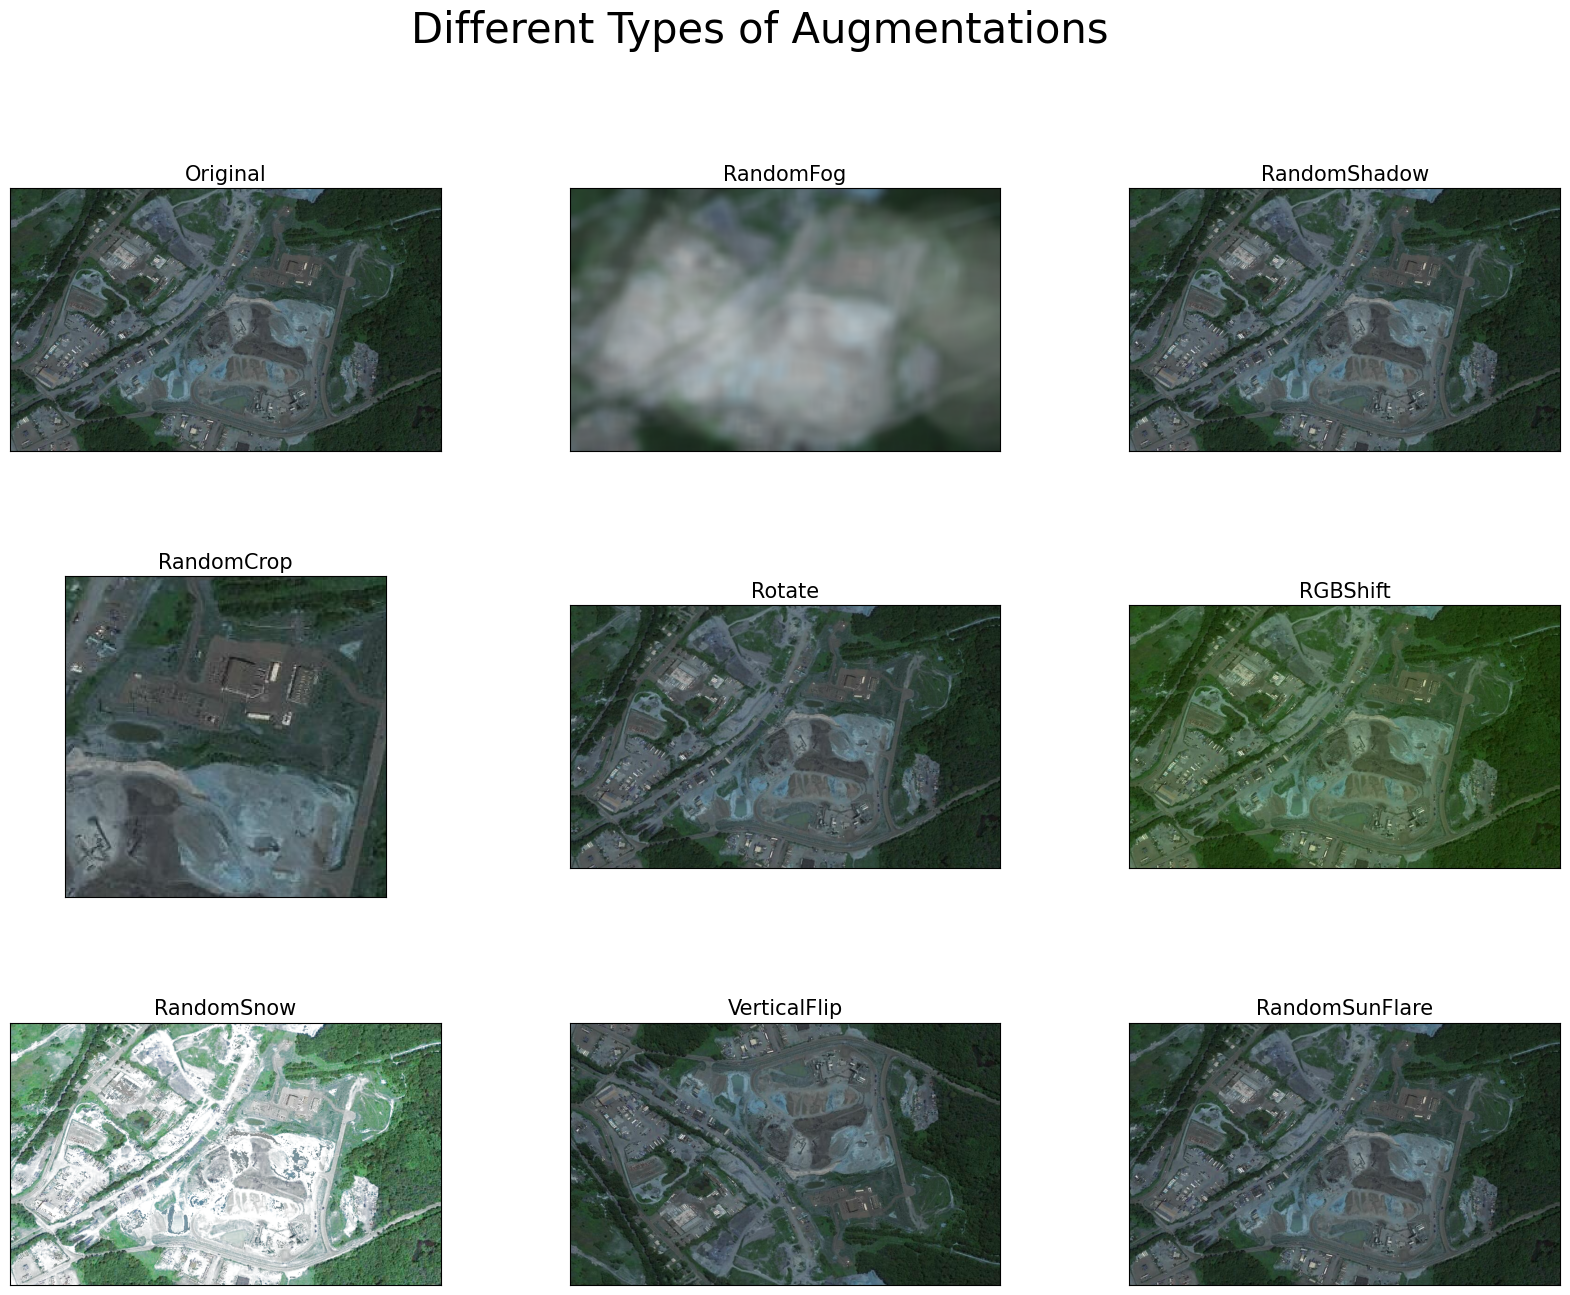

In [ ]:
chosen_img = read_img_neg(ID_neg[101])

albumentation_list = [A.RandomFog(p=1),
                      A.RandomShadow(p=0.5),
                      A.RandomCrop(p=1,height = 250, width = 250),
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1),
                      A.RandomSnow(p=1),
                      A.VerticalFlip(p=1),
                      A.RandomSunFlare(p=0.5)]

titles_list = ["Original",
               "RandomFog",
               "RandomShadow",
               "RandomCrop",
               "Rotate",
               "RGBShift",
               "RandomSnow",
               "VerticalFlip",
               "RandomSunFlare"]

img_matrix_list = [chosen_img]
for aug_type in albumentation_list:
    img = aug_type(image = chosen_img)['image']
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list,
                  titles_list,
                  ncols = 3,
                  main_title="Different Types of Augmentations")

#### Data Augmentation For Positive Imgaes

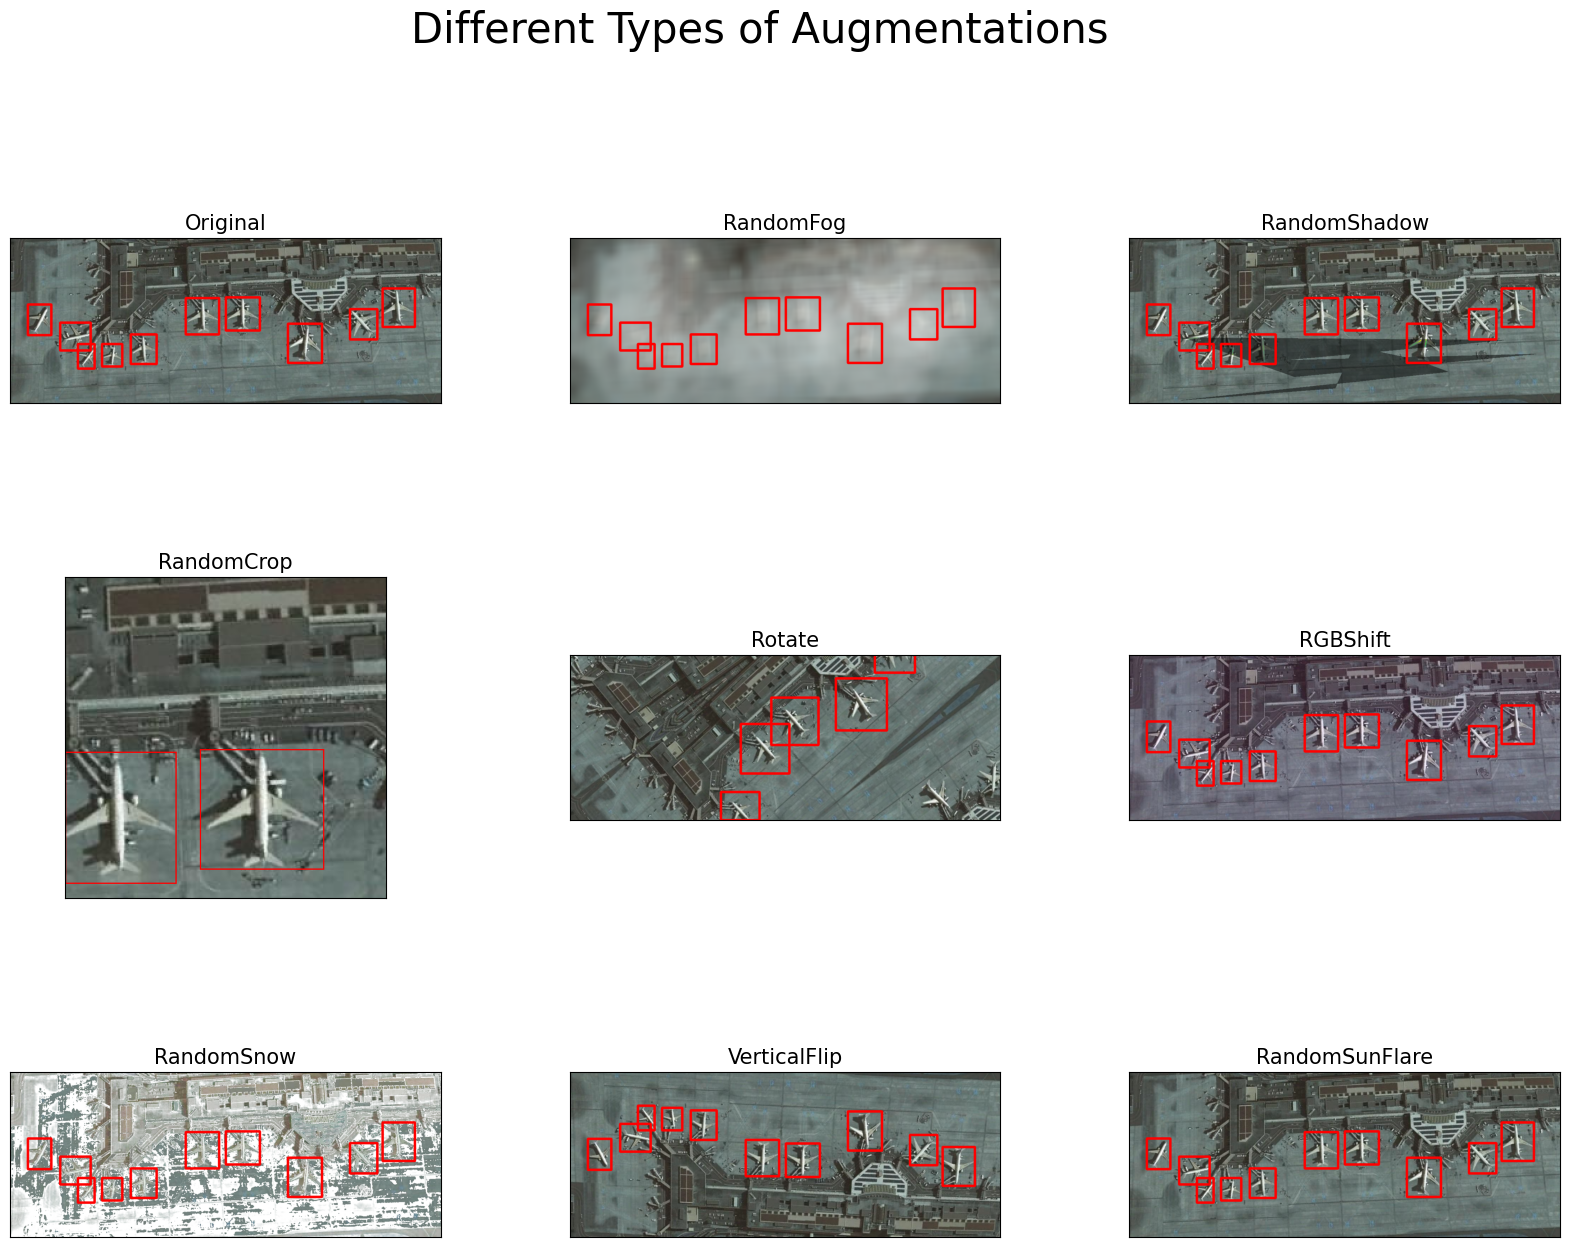

In [ ]:
chosen_img = read_img(ID[250])
bboxes = read_bboxes(BOX[250])
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}

albumentation_list = [
    A.Compose([A.RandomFog(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomShadow(p=0.5)], bbox_params=bbox_params),
    A.Compose([A.RandomCrop(p=1, height=250, width=250)], bbox_params=bbox_params),
    A.Compose([A.Rotate(p=1, limit=90)], bbox_params=bbox_params),
    A.Compose([A.RGBShift(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomSnow(p=1)], bbox_params=bbox_params),
    A.Compose([A.VerticalFlip(p=1)], bbox_params=bbox_params),
    A.Compose([A.RandomSunFlare(p=0.5)], bbox_params=bbox_params)
]

titles_list = [
    "Original",
    "RandomFog",
    "RandomShadow",
    "RandomCrop",
    "Rotate",
    "RGBShift",
    "RandomSnow",
    "VerticalFlip",
    "RandomSunFlare"
]

img_matrix_list = [draw_rect(chosen_img, bboxes)]

for aug_type in albumentation_list:
    anno = aug_type(image=chosen_img, bboxes=bboxes, labels=np.ones(len(bboxes)))
    img = draw_rect(anno['image'], anno['bboxes'])
    img_matrix_list.append(img)

plot_multiple_img(img_matrix_list, titles_list, ncols=3, main_title="Different Types of Augmentations")

In [ ]:
final_dataset = dataset_positive + dataset_negative

In [ ]:
img, target = final_dataset[2]
print(img.shape, '\n',target)

torch.Size([3, 1024, 1024]) 
 {'boxes': tensor([[420.9932, 274.1560, 534.9254, 374.0142],
        [390.4261, 343.1489, 512.6947, 435.7447],
        [555.7666, 341.3333, 637.7422, 472.0567],
        [632.1845, 368.5674, 725.2755, 501.1064],
        [262.5997, 479.3192, 490.4641, 706.2695]]), 'labels': tensor([5, 5, 6, 6, 4]), 'area': tensor([11377.0518, 11321.5586, 10716.1260, 12338.1807, 51713.8945]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': 2}


## **Phase 4: Modeling**

### split the dataset in train and test sets

In our work, the total number of objects in the dataset is divided into 70% and 30% for training and testing in class level

In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(final_dataset)).tolist()


test_split = 0.3
tsize = int(len(final_dataset)*test_split)
dataset = torch.utils.data.Subset(final_dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(final_dataset, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)

In [ ]:
def get_object_detection_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

SGD optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 11

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/56]  eta: 0:04:20  lr: 0.000096  loss: 2.9543 (2.9543)  loss_classifier: 2.4560 (2.4560)  loss_box_reg: 0.1585 (0.1585)  loss_objectness: 0.3256 (0.3256)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 4.6584  data: 0.8714  max mem: 8298
Epoch: [0]  [10/56]  eta: 0:01:29  lr: 0.001004  loss: 2.1394 (1.9149)  loss_classifier: 1.6742 (1.5080)  loss_box_reg: 0.1857 (0.2057)  loss_objectness: 0.1730 (0.1831)  loss_rpn_box_reg: 0.0155 (0.0182)  time: 1.9519  data: 0.1143  max mem: 8475
Epoch: [0]  [20/56]  eta: 0:01:06  lr: 0.001912  loss: 1.0888 (1.4903)  loss_classifier: 0.6615 (1.0838)  loss_box_reg: 0.2389 (0.2366)  loss_objectness: 0.1220 (0.1531)  loss_rpn_box_reg: 0.0155 (0.0168)  time: 1.7012  data: 0.0391  max mem: 8475
Epoch: [0]  [30/56]  eta: 0:00:47  lr: 0.002820  loss: 0.9129 (1.2891)  loss_classifier: 0.4671 (0.8723)  loss_box_reg: 0.3055 (0.2679)  loss_objectness: 0.0990 (0.1320)  loss_rpn_box_reg: 0.0151 (0.0169)  time: 1.7418  data: 0.0404  max mem: 8475
Epoch: [

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
img, target = dataset_test[229]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', prediction['labels'])
print('real #boxes: ', target['labels'])

predicted #boxes:  tensor([7, 6, 9], device='cuda:0')
real #boxes:  tensor([7])


In [ ]:
def plot_img_bbox(img, target):
    img = img.permute(1, 2, 0)
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(6, 6)
    a.imshow(img)

    boxes = target["boxes"]
    classes = target["labels"]

    for bbox, cls in zip(boxes, classes):
        x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
        a.text(x, y, str(mapping_dict[cls.item()]), color='y')

    plt.show()

EXPECTED OUTPUT


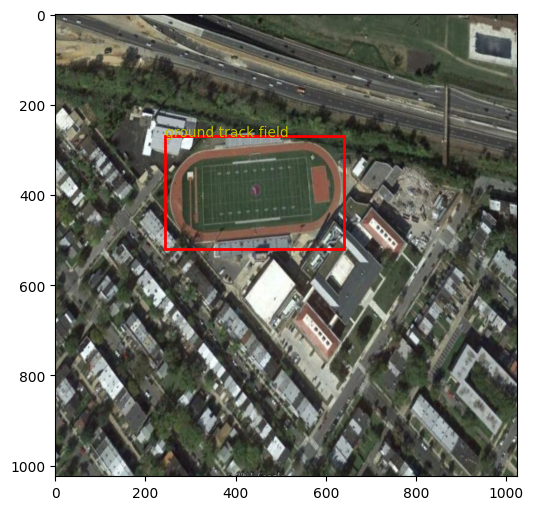

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox((img), target)

In [ ]:
def plot_img_bbox_pred(img, target):
    img = img.permute(1, 2, 0).cpu()  
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img)

    boxes = target["boxes"].cpu() 
    classes = target["labels"]

    for bbox, cls in zip(boxes, classes):
        x, y, width, height = bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        a.add_patch(rect)
        a.text(x, y, str(mapping_dict[cls.item()]), color='y')

    plt.show()

MODEL OUTPUT


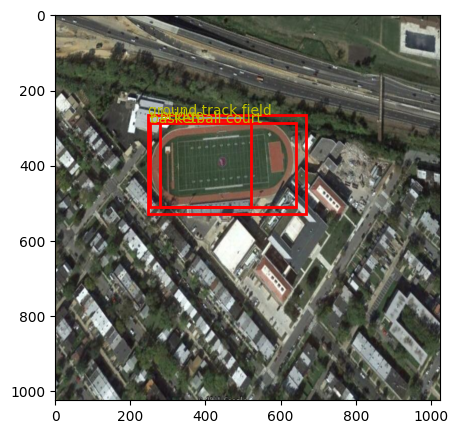

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox_pred(img, prediction)

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.50):

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

NMS APPLIED MODEL OUTPUT


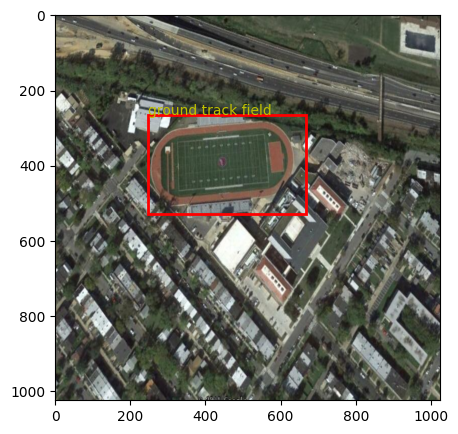

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.3)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox_pred(img, nms_prediction)

In [ ]:
coco_logger = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/24]  eta: 0:00:43  model_time: 0.8886 (0.8886)  evaluator_time: 0.0311 (0.0311)  time: 1.8245  data: 0.8527  max mem: 8477
Test:  [23/24]  eta: 0:00:01  model_time: 0.8594 (0.8704)  evaluator_time: 0.0387 (0.0577)  time: 1.0086  data: 0.0405  max mem: 8477
Test: Total time: 0:00:24 (1.0366 s / it)
Averaged stats: model_time: 0.8594 (0.8704)  evaluator_time: 0.0387 (0.0577)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ IoU=

In [ ]:
metrics = {
    "AP": [],       
    "AP_50": [],        
    "AP_75": [],        
    "AP_small": [],
    "AP_medium": [],
    "AP_large": [],
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": []
}

pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_small = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_medium = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_large = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")

with open('/kaggle/input/evaluation/sgd.txt', 'r') as file:
    file_content = file.read()

    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])
    metrics["AP_small"].extend([float(x) for x in pattern_ap_small.findall(file_content)])
    metrics["AP_medium"].extend([float(x) for x in pattern_ap_medium.findall(file_content)])
    metrics["AP_large"].extend([float(x) for x in pattern_ap_large.findall(file_content)])

    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

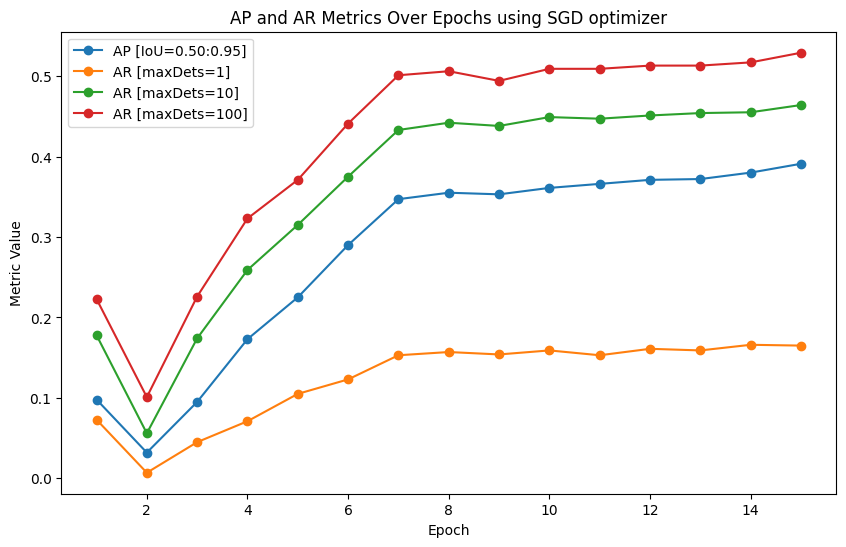

In [ ]:
epochs = list(range(1, len(metrics["AP"]) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, metrics["AP"], label='AP [IoU=0.50:0.95]', marker='o')

plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')

plt.title('AP and AR Metrics Over Epochs using SGD optimizer')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

In [ ]:
import pickle


In [ ]:
Filename = "FRCNNsgd.pkl"


In [ ]:
with open(Filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open(Filename, 'rb') as file:
    model_sgd = pickle.load(file)
#model

ADAM optimizer

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/56]  eta: 0:02:36  lr: 0.000096  loss: 0.3780 (0.3780)  loss_classifier: 0.1368 (0.1368)  loss_box_reg: 0.2045 (0.2045)  loss_objectness: 0.0240 (0.0240)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 2.7917  data: 0.7980  max mem: 8707
Epoch: [0]  [10/56]  eta: 0:01:31  lr: 0.001004  loss: 0.6997 (1.0832)  loss_classifier: 0.3820 (0.6262)  loss_box_reg: 0.2150 (0.2840)  loss_objectness: 0.0662 (0.1501)  loss_rpn_box_reg: 0.0133 (0.0230)  time: 1.9910  data: 0.0931  max mem: 9023
Epoch: [0]  [20/56]  eta: 0:01:10  lr: 0.001912  loss: 0.9166 (1.0885)  loss_classifier: 0.4378 (0.6129)  loss_box_reg: 0.2070 (0.2693)  loss_objectness: 0.1200 (0.1777)  loss_rpn_box_reg: 0.0239 (0.0285)  time: 1.9174  data: 0.0236  max mem: 9024
Epoch: [0]  [30/56]  eta: 0:00:49  lr: 0.002820  loss: 0.8401 (1.0224)  loss_classifier: 0.4094 (0.5214)  loss_box_reg: 0.1844 (0.2299)  loss_objectness: 0.1706 (0.2371)  loss_rpn_box_reg: 0.0275 (0.0340)  time: 1.8677  data: 0.0252  max mem: 9024
Epoch: [

In [ ]:
metrics = {
    "AP": [],          
    "AP_50": [],        
    "AP_75": [],        
    "AP_small": [],
    "AP_medium": [],
    "AP_large": [],
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": []
}

pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_small = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_medium = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_large = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")

with open('/kaggle/input/evaluation/adam.txt', 'r') as file:
    file_content = file.read()

    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])
    metrics["AP_small"].extend([float(x) for x in pattern_ap_small.findall(file_content)])
    metrics["AP_medium"].extend([float(x) for x in pattern_ap_medium.findall(file_content)])
    metrics["AP_large"].extend([float(x) for x in pattern_ap_large.findall(file_content)])

    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

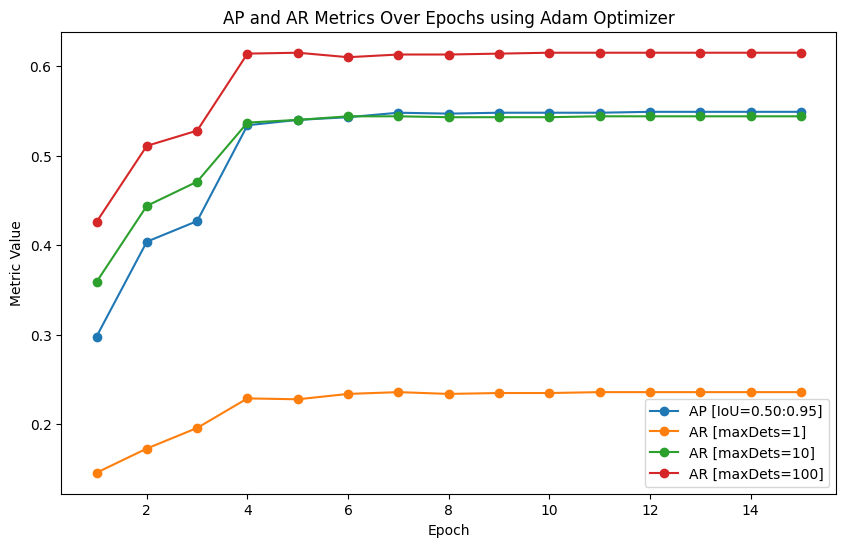

In [ ]:
epochs = list(range(1, len(metrics["AP"]) + 1))
plt.figure(figsize=(10, 6))

plt.plot(epochs, metrics["AP"], label='AP [IoU=0.50:0.95]', marker='o')

plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')

plt.title('AP and AR Metrics Over Epochs using Adam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

In [ ]:

Filename = "RCNNadamn.pkl"

torch.save(model.state_dict(), filename)
with open(Filename, 'wb') as file:
    pickle.dump(model, file)


with open(Filename, 'rb') as file:
    model_adam = pickle.load(file)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

RMS PROB Optimizer

In [ ]:
optimizer = torch.optim.RMSprop(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/56]  eta: 0:03:10  lr: 0.000096  loss: 0.2856 (0.2856)  loss_classifier: 0.0846 (0.0846)  loss_box_reg: 0.1761 (0.1761)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0177 (0.0177)  time: 3.3960  data: 1.3892  max mem: 9133
Epoch: [0]  [10/56]  eta: 0:01:38  lr: 0.001004  loss: 0.2833 (0.2678)  loss_classifier: 0.0898 (0.0860)  loss_box_reg: 0.1704 (0.1645)  loss_objectness: 0.0057 (0.0065)  loss_rpn_box_reg: 0.0110 (0.0108)  time: 2.1359  data: 0.1642  max mem: 9152
Epoch: [0]  [20/56]  eta: 0:01:13  lr: 0.001912  loss: 0.2833 (0.2903)  loss_classifier: 0.0926 (0.0972)  loss_box_reg: 0.1704 (0.1737)  loss_objectness: 0.0070 (0.0082)  loss_rpn_box_reg: 0.0111 (0.0112)  time: 1.9884  data: 0.0431  max mem: 9152
Epoch: [0]  [30/56]  eta: 0:00:51  lr: 0.002820  loss: 0.3110 (0.2876)  loss_classifier: 0.0979 (0.0952)  loss_box_reg: 0.1652 (0.1728)  loss_objectness: 0.0074 (0.0083)  loss_rpn_box_reg: 0.0114 (0.0112)  time: 1.9241  data: 0.0404  max mem: 9152
Epoch: [

In [ ]:
Filename = "RCNNrmsprob.pkl"
torch.save(model.state_dict(), filename)
with open(Filename, 'wb') as file:
    pickle.dump(model, file)
with open(Filename, 'rb') as file:
    model_rmsprob = pickle.load(file)


In [ ]:
metrics = {
    "AP": [],          
    "AP_50": [],       
    "AP_75": [],      
    "AP_small": [],
    "AP_medium": [],
    "AP_large": [],
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": []
}

pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_small = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_medium = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_large = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")

with open('/kaggle/input/evaluation/RMSprob.txt', 'r') as file:
    file_content = file.read()

    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])
    metrics["AP_small"].extend([float(x) for x in pattern_ap_small.findall(file_content)])
    metrics["AP_medium"].extend([float(x) for x in pattern_ap_medium.findall(file_content)])
    metrics["AP_large"].extend([float(x) for x in pattern_ap_large.findall(file_content)])

    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

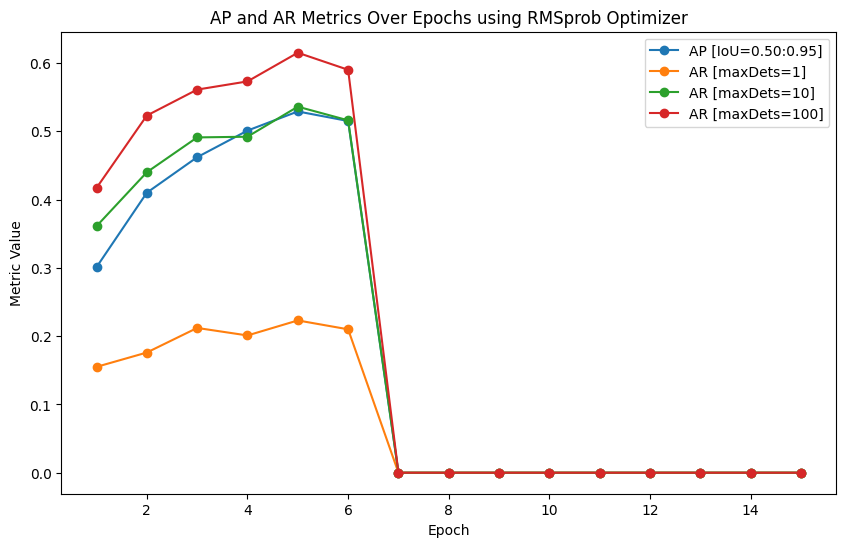

In [ ]:
epochs = list(range(1, len(metrics["AP"]) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, metrics["AP"], label='AP [IoU=0.50:0.95]', marker='o')

plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')

plt.title('AP and AR Metrics Over Epochs using RMSprob Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

Epoch: [0]  [ 0/56]  eta: 0:02:59  lr: 0.000019  loss: 2.9919 (2.9919)  loss_classifier: 2.4124 (2.4124)  loss_box_reg: 0.1473 (0.1473)  loss_objectness: 0.4053 (0.4053)  loss_rpn_box_reg: 0.0269 (0.0269)  time: 3.2077  data: 1.2178  max mem: 8622
Epoch: [0]  [10/56]  eta: 0:01:35  lr: 0.000201  loss: 1.2877 (1.6862)  loss_classifier: 0.7218 (1.2093)  loss_box_reg: 0.3406 (0.3088)  loss_objectness: 0.1259 (0.1477)  loss_rpn_box_reg: 0.0185 (0.0204)  time: 2.0825  data: 0.1428  max mem: 8949
Epoch: [0]  [20/56]  eta: 0:01:14  lr: 0.000382  loss: 1.0344 (1.3087)  loss_classifier: 0.5933 (0.8554)  loss_box_reg: 0.3081 (0.3270)  loss_objectness: 0.0592 (0.1065)  loss_rpn_box_reg: 0.0163 (0.0199)  time: 2.0067  data: 0.0377  max mem: 8956
Epoch: [0]  [30/56]  eta: 0:00:52  lr: 0.000564  loss: 0.7547 (1.1306)  loss_classifier: 0.3999 (0.7034)  loss_box_reg: 0.2763 (0.3079)  loss_objectness: 0.0579 (0.0993)  loss_rpn_box_reg: 0.0161 (0.0200)  time: 1.9884  data: 0.0400  max mem: 8956
Epoch: [

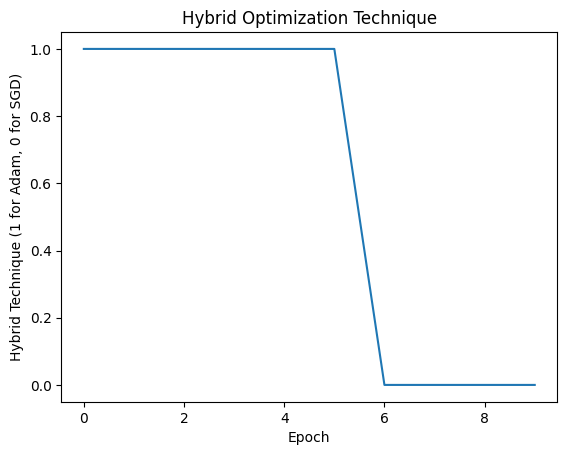

In [ ]:
def hybrid_optimizer(model, params_adam, params_sgd, lr=0.001, momentum=0.9, weight_decay=0.0005, step_size=3, gamma=0.1):
    optimizer_adam = optim.Adam(params_adam, lr=lr, weight_decay=weight_decay)
    optimizer_sgd = optim.SGD(params_sgd, lr=lr, momentum=momentum, weight_decay=weight_decay)

    lr_scheduler = StepLR(optimizer_sgd, step_size=step_size, gamma=gamma)

    optimizer = optimizer_adam

    return optimizer, optimizer_adam, optimizer_sgd, lr_scheduler

num_classes = 11
model = get_object_detection_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params_adam = [p for p in model.parameters() if p.requires_grad]
params_sgd = [p for p in model.parameters() if p.requires_grad]

optimizer, optimizer_adam, optimizer_sgd, lr_scheduler = hybrid_optimizer(model, params_adam, params_sgd)

num_epochs = 10
hybrid_results = []  
is_adam = True  

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    hybrid_results.append(int(is_adam))  

    if epoch == 5:
        optimizer = optimizer_sgd
        lr_scheduler.step() 
        is_adam = False

    evaluate(model, data_loader_test, device=device)

plt.plot(hybrid_results)
plt.xlabel('Epoch')
plt.ylabel('Hybrid Technique (1 for Adam, 0 for SGD)')
plt.title('Hybrid Optimization Technique')
plt.show()


In [ ]:
metrics = {
    "AP": [],          
    "AP_50": [],     
    "AP_75": [],       
    "AP_small": [],
    "AP_medium": [],
    "AP_large": [],
    "AR_1": [],
    "AR_10": [],
    "AR_100": [],
    "AR_small": [],
    "AR_medium": [],
    "AR_large": []
}

pattern_ap = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_50 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_75 = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.75 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_small = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_medium = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ap_large = re.compile(r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_1 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=  1 \] = (\d+\.\d+)")
pattern_ar_10 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets= 10 \] = (\d+\.\d+)")
pattern_ar_100 = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=   all \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_small = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= small \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_medium = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=medium \| maxDets=100 \] = (\d+\.\d+)")
pattern_ar_large = re.compile(r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area= large \| maxDets=100 \] = (\d+\.\d+)")

with open('/kaggle/input/evaluation/hybrid.txt', 'r') as file:
    file_content = file.read()

    metrics["AP"].extend([float(x) for x in pattern_ap.findall(file_content)])
    metrics["AP_50"].extend([float(x) for x in pattern_ap_50.findall(file_content)])
    metrics["AP_75"].extend([float(x) for x in pattern_ap_75.findall(file_content)])
    metrics["AP_small"].extend([float(x) for x in pattern_ap_small.findall(file_content)])
    metrics["AP_medium"].extend([float(x) for x in pattern_ap_medium.findall(file_content)])
    metrics["AP_large"].extend([float(x) for x in pattern_ap_large.findall(file_content)])

    metrics["AR_1"].extend([float(x) for x in pattern_ar_1.findall(file_content)])
    metrics["AR_10"].extend([float(x) for x in pattern_ar_10.findall(file_content)])
    metrics["AR_100"].extend([float(x) for x in pattern_ar_100.findall(file_content)])
    metrics["AR_small"].extend([float(x) for x in pattern_ar_small.findall(file_content)])
    metrics["AR_medium"].extend([float(x) for x in pattern_ar_medium.findall(file_content)])
    metrics["AR_large"].extend([float(x) for x in pattern_ar_large.findall(file_content)])

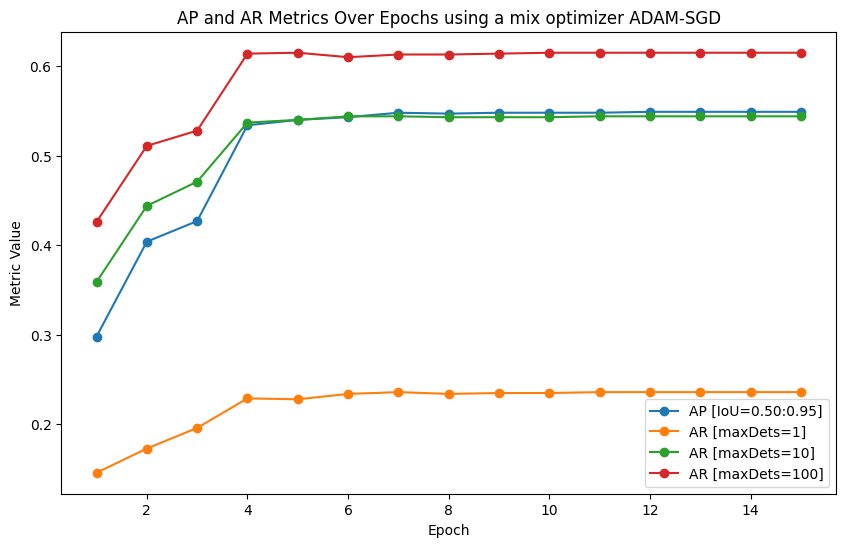

In [ ]:
epochs = list(range(1, len(metrics["AP"]) + 1))
plt.figure(figsize=(10, 6))

plt.plot(epochs, metrics["AP"], label='AP [IoU=0.50:0.95]', marker='o')

plt.plot(epochs, metrics["AR_1"], label='AR [maxDets=1]', marker='o')
plt.plot(epochs, metrics["AR_10"], label='AR [maxDets=10]', marker='o')
plt.plot(epochs, metrics["AR_100"], label='AR [maxDets=100]', marker='o')

plt.title('AP and AR Metrics Over Epochs using a mix optimizer ADAM-SGD')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

In [ ]:
recall_values_SGD = [0.223, 0.101, 0.226, 0.323, 0.371, 0.441, 0.501, 0.506, 0.494, 0.509, 0.509, 0.513, 0.513, 0.517, 0.529]

precision_values_SGD = [0.098, 0.032, 0.095, 0.173, 0.225, 0.29, 0.347, 0.355, 0.353, 0.361, 0.366, 0.371, 0.372, 0.38, 0.391]

In [ ]:
recall_values_RMSprop = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision_values_RMSprop = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
recall_values_ADAMNSGD = [0.426, 0.511, 0.528, 0.614, 0.615, 0.61, 0.613, 0.613, 0.614, 0.615, 0.615, 0.615, 0.615, 0.615, 0.615]
precision_values_ADAMNSGD = [0.298, 0.404, 0.427, 0.534, 0.54, 0.543, 0.548, 0.547, 0.548, 0.548, 0.548, 0.549, 0.549, 0.549, 0.549]

In [ ]:
recall_values_SGDADAMN = [0.417, 0.523, 0.561, 0.573, 0.615, 0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision_values_SGDADAMN = [0.301, 0.41, 0.462, 0.501, 0.529, 0.515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
recall_values_Adam = [0.18, 0.351, 0.356, 0.545, 0.552, 0.558, 0.576, 0.576, 0.576, 0.574, 0.578, 0.579, 0.58, 0.58, 0.58]
precision_values_Adam = [0.086, 0.209, 0.212, 0.408, 0.429, 0.452, 0.478, 0.482, 0.483, 0.485, 0.488, 0.49, 0.491, 0.491, 0.491]

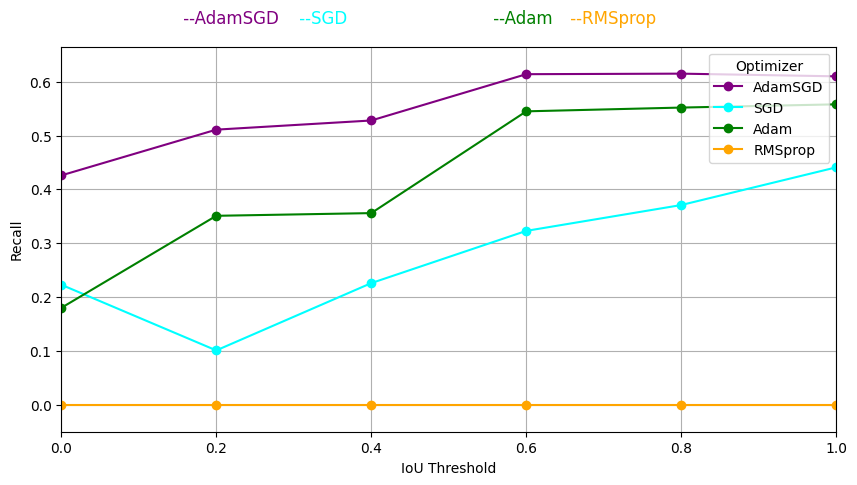

In [ ]:
iou_thresholds = [i / 5 for i in range(6)]
recall_values_ADAMNSGD = recall_values_ADAMNSGD[:6]  
recall_values_SGD = recall_values_SGD[:6]            

recall_values_Adam = recall_values_Adam[:6]          
recall_values_RMSprop = recall_values_RMSprop[:6]   

plt.figure(figsize=(10, 5))
plt.plot(iou_thresholds, recall_values_ADAMNSGD, marker='o', linestyle='-', color='purple', label='AdamSGD')
plt.plot(iou_thresholds, recall_values_SGD, marker='o', linestyle='-', color='cyan', label='SGD')

plt.plot(iou_thresholds, recall_values_Adam, marker='o', linestyle='-', color='green', label='Adam')
plt.plot(iou_thresholds, recall_values_RMSprop, marker='o', linestyle='-', color='orange', label='RMSprop')

plt.text(0.15, 1.05, ' --AdamSGD', color='purple', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.text(0.30, 1.05, ' --SGD', color='cyan', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)
plt.text(0.55, 1.05, ' --Adam', color='green', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.text(0.65, 1.05, ' --RMSprop', color='orange', fontsize=12, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.xlabel('IoU Threshold')
plt.ylabel('Recall')
plt.xticks(iou_thresholds)
plt.xlim(0, 1)
plt.ylim(min(min(recall_values_ADAMNSGD, recall_values_SGD, recall_values_SGDADAMN, recall_values_Adam, recall_values_RMSprop)) - 0.05,
         max(max(recall_values_ADAMNSGD, recall_values_SGD, recall_values_SGDADAMN, recall_values_Adam, recall_values_RMSprop)) + 0.05)
plt.grid(True)
plt.legend(title='Optimizer', loc='upper right')

plt.show()
